In [1]:
import pysam as ps
import numpy as np
import collections
import matplotlib.pyplot as plt
from numpy.core.defchararray import array, center
import pysam as ps
import numpy as np
from collections import defaultdict
from scipy.ndimage.measurements import label, standard_deviation
from scipy.stats.mstats_basic import kstest, normaltest
from sklearn.cluster import KMeans
import sys
from scipy.signal import savgol_filter
import math
from subprocess import call
import os.path
from utils import Gene, TSS, Point
from scipy import stats
from sklearn import svm
import sympy
import math
from math import e
import random
from keras import Model
from keras.models import load_model
import numpy as np
import os
import pandas as pd

2021-12-06 21:17:23.285915: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-06 21:17:23.285954: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [260]:
dic = {
    'gene':'./data/gene/GRCh37.gene.bed',
    'non_gene':'./data/gene/non_gene.bed',
    'non_gene_4':'./data/gene/non_gene_4.bed',
    'non_gene_2':'./data/gene/non_gene_2.bed',
    'fasta':'/home/jiay/Desktop/hg19/hg19.fa',
    'bam1':'./data/051.bam',
    'bam2':'./data/051_2.bam',
    'bam3':'./data/051_3.bam',
    'bam123':'./data/051_123.bam',
    'bam4':'./data/051_4.bam',
    'bam5':'./data/051_5.bam',
    'TSS_low':'./data/gene/low_expressed.bed',
    'TSS_HK':'./data/gene/HK.bed',
    'TSS_silent':'./data/gene/silent_gene_TSS.bed',
    'ATAC_hema_1':'./data/gene/ATAC_hema_1.bed',
    'ATAC_hema_2':'./data/gene/ATAC_hema_2.bed',
    'ATAC_Bcell':'./data/gene/ATAC_Bcell.bed',
    'ATAC_Bcell':'./data/gene/ATAC_Bcell.bed',
    'ATAC_Brain':'./data/gene/ATAC_Brain.bed'
    }
TSS_HK = []
# with open(dic['TSS_HK'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         if ll[0] in ['1','2','3']:
#             TSS_HK.append(TSS(ll[0], int(int(ll[1])+1000)))
# with open(dic['ATAC_hema_1'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         TSS_HK.append(TSS(ll[0], int((int(ll[1])+int(ll[2]))/2)))
        


TSS_NonGene = []
with open(dic['non_gene'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        TSS_NonGene.append(TSS(ll[0], int(ll[1])+int(1000)))
with open(dic['ATAC_Bcell'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        if ll[0] in ['1'] and ll[2] == '1':
            TSS_HK.append(TSS(ll[0],int(ll[1])))

bamfile = ps.AlignmentFile(dic['bam123'],'rb')

TSS_NonGene = TSS_NonGene[:len(TSS_HK)]

TSSes_x = TSS_HK + TSS_NonGene
TSSes_y = [1]*len(TSS_HK) + [0]*len(TSS_NonGene)
perm = random.sample(range(len(TSSes_x)),len(TSSes_x))
TSSes_x = np.array(TSSes_x)
TSSes_y = np.array(TSSes_y)
TSSes_x = TSSes_x[perm[:len(perm)]]
TSSes_y = TSSes_y[perm[:len(perm)]]
labels = TSSes_y
up = 1000
down = 1000


In [261]:
print(len(TSS_HK))

2077


In [262]:
#lstm
feature_matrix = []
for j, tss in enumerate(TSSes_x):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
    up_end = np.zeros(up+down, dtype= int)
    down_end = np.zeros(up+down, dtype= int)
    long = np.zeros(up+down, dtype= int)
    short = np.zeros(up+down, dtype= int)
    cov = np.zeros(up+down, dtype= int)
    wps = np.zeros(up+down, dtype=float)
    win = 120
    for r in bamfile.fetch(chrom[-1], start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            ss = r.reference_start - start
            ee = r.reference_start - start + abs(r.isize)
            if ss >= 0:
                up_end[ss] += 1
            else:
                ss = 0
            if ee < end - start:
                down_end[ee] += 1
            else:
                ee = end - start
            for i in range(ss, ee):
                cov[i] += 1
            if 200 >= abs(r.isize) > 130:
                for i in range(ss, ee):
                    long[i] += 1
            if abs(r.isize) <= 130:
                for i in range(ss, ee):
                    short[i] += 1
            # wps_total
            region1 = int(max(0, ss + win/2))
            region2 = int(min(ee - win/2, end-start))
            i = region1
            while i < region2:
                wps[i] += 1
                i = i+1
            # wps_part
            region1 = int(max(0, ss - win/2))
            region2 = int(min(end-start, ss + win/2))
            i = region1
            while i < region2:
                wps[i] -= 1
                i = i + 1
            # wps_part
            region1 = int(max(ee - win/2, 0))
            region2 = int(min(ee + win/2, end-start))
            i = region1
            while i < region2:
                wps[i] -= 1
                i = i+1
    k = 0
    win = 40
    feature_win = np.zeros((int((up+down)/win), 4), dtype= int)
    while k < (up+down)/win:
        ss = k * win
        ee = k * win + win
        ff = []
        ff.append(int(round(np.mean(cov[ss:ee]))))
        ff.append(int(round(np.mean(long[ss:ee]-short[ss:ee]))))
        ff.append(int(round(np.sum(abs(up_end[ss:ee]-down_end[ss:ee])))))
        ff.append(int(round(np.mean(wps[ss:ee]))))
        feature_win[k] = np.array(ff)
        k = k + 1
    feature_matrix.append(feature_win)
feature_matrix = np.array(feature_matrix)

lstm_x = []
for mat in feature_matrix:
    lstm_x.append(mat)
lstm_x = np.array(lstm_x)


In [265]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import KFold
def creat_model():
    model = keras.Sequential()
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(50, return_sequences=True),input_shape=(lstm_x.shape[1], lstm_x.shape[2])))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(300, activation='relu', kernel_regularizer=None, bias_regularizer=None))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=None, bias_regularizer=None))
    model.add(keras.layers.Dropout(0.2))
    # model.add(keras.layers.Dense(2, activation='sigmoid', kernel_regularizer=None, bias_regularizer=None,name='4'))
    model.add(keras.layers.Dense(2, activation='softmax', kernel_regularizer=None, bias_regularizer=None))
    adam = keras.optimizers.Adam(lr=1e-4)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    return model

n_split = 5
x = lstm_x
y = keras.utils.to_categorical(labels)
id = []
ypred = np.empty(shape=[0,2])
for train_index, test_index in KFold(n_split).split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = creat_model()
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    model.fit(x_train, y_train, epochs=200, batch_size=128, validation_split=0.1, callbacks=[EarlyStopping(patience=10)], shuffle=True, verbose=2)
    pp = model.predict(x_test)
    id += list(test_index)
    ypred = np.concatenate((ypred, pp))
xsamed = x[id]
ylabed = labels[id]

Epoch 1/200
24/24 - 13s - loss: 0.6543 - accuracy: 0.6147 - val_loss: 0.6316 - val_accuracy: 0.6396
Epoch 2/200
24/24 - 1s - loss: 0.6107 - accuracy: 0.6763 - val_loss: 0.6086 - val_accuracy: 0.6607
Epoch 3/200
24/24 - 1s - loss: 0.5947 - accuracy: 0.6839 - val_loss: 0.6066 - val_accuracy: 0.6547
Epoch 4/200
24/24 - 2s - loss: 0.5866 - accuracy: 0.6980 - val_loss: 0.6088 - val_accuracy: 0.6727
Epoch 5/200
24/24 - 1s - loss: 0.5747 - accuracy: 0.7080 - val_loss: 0.6066 - val_accuracy: 0.6727
Epoch 6/200
24/24 - 1s - loss: 0.5775 - accuracy: 0.7033 - val_loss: 0.6069 - val_accuracy: 0.6637
Epoch 7/200
24/24 - 1s - loss: 0.5727 - accuracy: 0.7043 - val_loss: 0.6015 - val_accuracy: 0.6697
Epoch 8/200
24/24 - 1s - loss: 0.5588 - accuracy: 0.7054 - val_loss: 0.6034 - val_accuracy: 0.6697
Epoch 9/200
24/24 - 1s - loss: 0.5628 - accuracy: 0.7134 - val_loss: 0.6085 - val_accuracy: 0.6817
Epoch 10/200
24/24 - 1s - loss: 0.5516 - accuracy: 0.7137 - val_loss: 0.5992 - val_accuracy: 0.6667
Epoch 11

In [264]:
t = [[],[]]
for i in range(len(ylabed)):
    t[ylabed[i]].append(i)
t0 = np.mean([ypred[i][0]for i in t[0]])
t1 = np.mean([ypred[i][1]for i in t[1]])
print(t0,t1)
yconf = []
for i in range(len(ypred)):
    if ypred[i][0] > ypred[i][1] and ypred[i][0] >= t0:
        yconf.append(0)
    elif ypred[i][1] > ypred[i][0] and ypred[i][1] >= t1:
        yconf.append(1)
    else:
        yconf.append(-1)
matrix_c = np.zeros((2,2),dtype=int)
for i in range(len(ylabed)):
    if yconf[i] == -1:
        continue
    matrix_c[ylabed[i]][yconf[i]] += 1

matrix_c1 = np.zeros((2,2),dtype=float)
for i in range(2):
    for j in range(2):
        matrix_c1[i][j] = matrix_c[i][j] * len([k for k in ylabed if k == i]) / np.sum(matrix_c[i])
print(matrix_c)
print(matrix_c1)
matrix_q = np.zeros((2,2),dtype=float)
for i in range(2):
    for j in range(2):
        matrix_q = matrix_c1 / np.sum(matrix_c1)
print(matrix_q)
print(len([i for i in yconf if i == -1]))

0.6902994645132128 0.6366970066965831
[[1412  276]
 [ 644 1146]]
[[1737.3957346   339.6042654 ]
 [ 747.25586592 1329.74413408]]
[[0.41824645 0.08175355]
 [0.17988827 0.32011173]]
676


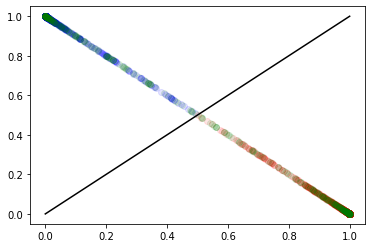

In [250]:
'''method 1'''
# exclude_0 = []
# exclude_1 = []
# reserved = []
# for i, tt in enumerate(ypred):
#     if tt[0] > tt[1]:
#         if ylabed[i] != 0:
#             exclude_0.append(i)
#             continue
#     if tt[1] > tt[0]:
#         if ylabed[i] != 1:
#             exclude_1.append(i)
#             continue
#     reserved.append(i)

# # print(len(exclude))
# # print(len(reserved),len(ypred))

# ex_0 = np.array([ypred[i] for i in exclude_0])
# ex_1 = np.array([ypred[i] for i in exclude_1])
# re = np.array([ypred[i] for i in reserved])
# # plt.scatter(ypred[:,0],ypred[:,1])
# plt.scatter(ex_0[:,0],ex_0[:,1],color='r',alpha=0.1)
# plt.scatter(ex_1[:,0],ex_1[:,1],color='b',alpha=0.1)
# plt.scatter(re[:,0],re[:,1]-0.2,color='g',alpha=0.1)
# plt.plot([0,1],[0,1],color='black')
# plt.show()

exclude = []
reserved_0 = []
reserved_1 = []
for i, tt in enumerate(ypred):
    if tt[0] > tt[1]:
        if ylabed[i] != 0:
            exclude.append(i)
            continue
    if tt[1] > tt[0]:
        if ylabed[i] != 1:
            exclude.append(i)
            continue
    if ylabed[i] == 1:
        reserved_1.append(i)
    if ylabed[i] == 0:
        reserved_0.append(i)
ex = np.array([ypred[i] for i in exclude])
re_0 = np.array([ypred[i] for i in reserved_0])
re_1 = np.array([ypred[i] for i in reserved_1])


plt.scatter(re_1[:,0],re_1[:,1],color='b',alpha=0.1)
plt.scatter(re_0[:,0],re_0[:,1],color='r',alpha=0.1)
plt.scatter(ex[:,0],ex[:,1],color='g',alpha=0.1)
plt.plot([0,1],[0,1],color='black')
plt.show()

In [251]:
reserved_id = np.array(reserved_0 + reserved_1)
perm = random.sample(range(len(reserved_id)),len(reserved_id))
reserved_id = reserved_id[perm[:len(perm)]]
reserved_x = lstm_x[reserved_id]
reserved_y = labels[reserved_id]
model = creat_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.fit(reserved_x, keras.utils.to_categorical(reserved_y), epochs=200, batch_size=128, validation_split=0.1, callbacks=[EarlyStopping(patience=10),ModelCheckpoint(filepath='./cl_1.h5', save_best_only=True)], shuffle=True, verbose=2,)


Epoch 1/200
18/18 - 4s - loss: 0.4048 - accuracy: 0.8355 - val_loss: 0.1867 - val_accuracy: 0.9342
Epoch 2/200
18/18 - 1s - loss: 0.2095 - accuracy: 0.9212 - val_loss: 0.1355 - val_accuracy: 0.9506
Epoch 3/200
18/18 - 1s - loss: 0.1775 - accuracy: 0.9304 - val_loss: 0.1053 - val_accuracy: 0.9671
Epoch 4/200
18/18 - 1s - loss: 0.1466 - accuracy: 0.9473 - val_loss: 0.0984 - val_accuracy: 0.9671
Epoch 5/200
18/18 - 1s - loss: 0.1493 - accuracy: 0.9450 - val_loss: 0.0935 - val_accuracy: 0.9753
Epoch 6/200
18/18 - 1s - loss: 0.1150 - accuracy: 0.9652 - val_loss: 0.0778 - val_accuracy: 0.9794
Epoch 7/200
18/18 - 1s - loss: 0.0970 - accuracy: 0.9629 - val_loss: 0.0614 - val_accuracy: 0.9794
Epoch 8/200
18/18 - 1s - loss: 0.0919 - accuracy: 0.9638 - val_loss: 0.0577 - val_accuracy: 0.9794
Epoch 9/200
18/18 - 1s - loss: 0.0839 - accuracy: 0.9725 - val_loss: 0.0804 - val_accuracy: 0.9671
Epoch 10/200
18/18 - 1s - loss: 0.0807 - accuracy: 0.9716 - val_loss: 0.0989 - val_accuracy: 0.9588
Epoch 11/

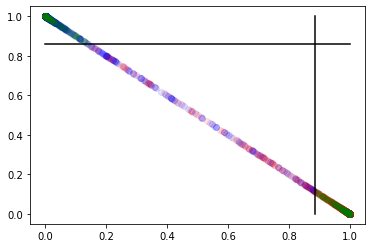

In [231]:
'''method 2'''
# exclude_0 = []
# exclude_1 = []
# reserved = []
# for i, tt in enumerate(yconf):
#     if tt == -1:
#         reserved.append(i)
#         continue
#     if ylabed[i] != yconf[i]:
#         if ylabed[i] == 0:
#             exclude_0.append(i)
#             continue
#         else:
#             exclude_1.append(i)
#             continue
#     reserved.append(i)
# ex_0 = np.array([ypred[i] for i in exclude_0])
# ex_1 = np.array([ypred[i] for i in exclude_1])
# re = np.array([ypred[i] for i in reserved])
# # plt.scatter(ypred[:,0],ypred[:,1])

# plt.scatter(re[:,0],re[:,1],color='g',alpha=0.1)
# plt.scatter(ex_0[:,0],ex_0[:,1],color='r',alpha=0.1)
# plt.scatter(ex_1[:,0],ex_1[:,1],color='b',alpha=0.1)
# plt.plot([t0,t0],[0,1],color='black')
# plt.plot([0,1],[t1,t1],color='black')
# plt.show()

exclude = []
reserved_0 = []
reserved_1 = []
for i, tt in enumerate(yconf):
    if tt == -1:
        if ylabed[i] == 0:
            reserved_0.append(i)
        else:
            reserved_1.append(i)
        continue
    if ylabed[i] != yconf[i]:
        if ylabed[i] == 0:
            exclude.append(i)
            continue
        else:
            exclude.append(i)
            continue
    if ylabed[i] == 0:
        reserved_0.append(i)
    else:
        reserved_1.append(i)
ex = np.array([ypred[i] for i in exclude])
re_0 = np.array([ypred[i] for i in reserved_0])
re_1 = np.array([ypred[i] for i in reserved_1])

plt.scatter(re_0[:,0],re_0[:,1],color='r',alpha=0.1)
plt.scatter(re_1[:,0],re_1[:,1],color='b',alpha=0.1)

plt.scatter(ex[:,0],ex[:,1],color='g',alpha=0.1)
plt.plot([t0,t0],[0,1],color='black')
plt.plot([0,1],[t1,t1],color='black')
plt.show()

In [235]:
reserved_id = np.array(reserved_0 + reserved_1)
perm = random.sample(range(len(reserved_id)),len(reserved_id))
reserved_id = reserved_id[perm[:len(perm)]]
reserved_x = lstm_x[reserved_id]
reserved_y = labels[reserved_id]
# train_x = reserved_x[:int(len(reserved_x)*0.8)]
# train_y = keras.utils.to_categorical(reserved_y[:int(len(reserved_y)*0.8)])
# test_x = reserved_x[int(len(reserved_x)*0.8):]
# test_y = keras.utils.to_categorical(reserved_y[int(len(reserved_y)*0.8):])
train_x = reserved_x
train_y = keras.utils.to_categorical(reserved_y)
model = creat_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.fit(train_x, train_y, epochs=200, batch_size=128, validation_split=0.1, callbacks=[EarlyStopping(patience=10),ModelCheckpoint(filepath='./cl.h5', save_best_only=True)], shuffle=True, verbose=2,)
# model.evaluate(test_x,test_y)
# print(len(exclude),len(reserved_1),len(reserved_0))
model = creat_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.fit(lstm_x, keras.utils.to_categorical(labels), epochs=200, batch_size=128, validation_split=0.1, callbacks=[EarlyStopping(patience=10),ModelCheckpoint(filepath='./nl.h5', save_best_only=True)], shuffle=True, verbose=2,)


/home/jiay/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/200
18/18 - 4s - loss: 0.5938 - accuracy: 0.7491 - val_loss: 0.4041 - val_accuracy: 0.8858
Epoch 2/200
18/18 - 1s - loss: 0.4082 - accuracy: 0.8575 - val_loss: 0.2929 - val_accuracy: 0.9252
Epoch 3/200
18/18 - 1s - loss: 0.3341 - accuracy: 0.8868 - val_loss: 0.2365 - val_accuracy: 0.9291
Epoch 4/200
18/18 - 1s - loss: 0.2940 - accuracy: 0.9066 - val_loss: 0.2051 - val_accuracy: 0.9252
Epoch 5/200
18/18 - 1s - loss: 0.2642 - accuracy: 0.9154 - val_loss: 0.1868 - val_accuracy: 0.9252
Epoch 6/200
18/18 - 1s - loss: 0.2456 - accuracy: 0.9241 - val_loss: 0.1716 - val_accuracy: 0.9331
Epoch 7/200
18/18 - 1s - loss: 0.2253 - accuracy: 0.9259 - val_loss: 0.1651 - val_accuracy: 0.9291
Epoch 8/200
18/18 - 1s - loss: 0.2100 - accuracy: 0.9333 - val_loss: 0.1467 - val_accuracy: 0.9409
Epoch 9/200
18/18 - 1s - loss: 0.2033 - accuracy: 0.9364 - val_loss: 0.1449 - val_accuracy: 0.9409
Epoch 10/200
18/18 - 1s - loss: 0.1874 - accuracy: 0.9417 - val_loss: 0.1347 - val_accuracy: 0.9449
Epoch 11/

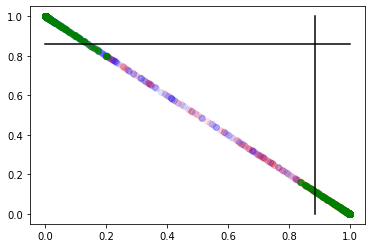

In [244]:
'''method 3'''
# num_0 = int(np.round(len(ylabed) * matrix_q[0][1]))
# num_1 = int(np.round(len(ylabed) * matrix_q[1][0]))
# # l_0 = np.array(sorted([[ypred[i][0],int(i)] for i in t[0]],key= lambda x: x[0]))
# l_0 = sorted([(ypred[i][0],int(i)) for i in t[0]],key= lambda x: x[0])
# # exclude_0 = l_0[:num_0][:,1]
# # reserved = l_0[num_0:][:,1]
# exclude_0 = [p[1] for p in l_0[:num_0]]
# reserved = [p[1] for p in l_0[num_0:]]
# print(exclude_0)
# l_1 = sorted([(ypred[i][1],int(i)) for i in t[1]],key= lambda x: x[0])
# exclude_1 = [p[1] for p in l_1[:num_1]]
# reserved = reserved + [p[1] for p in l_1[num_1:]]

# ex_0 = np.array([ypred[i] for i in exclude_0])
# ex_1 = np.array([ypred[i] for i in exclude_1])
# re = np.array([ypred[i] for i in reserved])
# # plt.scatter(ypred[:,0],ypred[:,1])

# plt.scatter(re[:,0],re[:,1],color='g',alpha=0.1)
# plt.scatter(ex_0[:,0],ex_0[:,1],color='r',alpha=0.5)
# plt.scatter(ex_1[:,0],ex_1[:,1],color='b',alpha=0.5)
# plt.plot([t0,t0],[0,1],color='black')
# plt.plot([0,1],[t1,t1],color='black')


num_0 = int(np.round(len(ylabed) * matrix_q[0][1]))
num_1 = int(np.round(len(ylabed) * matrix_q[1][0]))
l_0 = sorted([(ypred[i][0],int(i)) for i in t[0]],key= lambda x: x[0])

exclude = [p[1] for p in l_0[:num_0]]
reserved_0 = [p[1] for p in l_0[num_0:]]

l_1 = sorted([(ypred[i][1],int(i)) for i in t[1]],key= lambda x: x[0])
exclude += [p[1] for p in l_1[:num_1]]
reserved_1 = [p[1] for p in l_1[num_1:]]

ex = np.array([ypred[i] for i in exclude])
re_1 = np.array([ypred[i] for i in reserved_1])
re_0 = np.array([ypred[i] for i in reserved_0])
# plt.scatter(ypred[:,0],ypred[:,1])

plt.scatter(re_0[:,0],re_0[:,1],color='r',alpha=0.1)
plt.scatter(re_1[:,0],re_1[:,1],color='b',alpha=0.1)

plt.scatter(ex[:,0],ex[:,1],color='g',alpha=0.5)
plt.plot([t0,t0],[0,1],color='black')
plt.plot([0,1],[t1,t1],color='black')

In [245]:
reserved_id = np.array(reserved_0 + reserved_1)
perm = random.sample(range(len(reserved_id)),len(reserved_id))
reserved_id = reserved_id[perm[:len(perm)]]
train_x = lstm_x[reserved_id]
train_y = labels[reserved_id]
print(len(train_x))
model = creat_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.fit(train_x, keras.utils.to_categorical(train_y), epochs=200, batch_size=128, validation_split=0.1, callbacks=[EarlyStopping(patience=10),ModelCheckpoint(filepath='./cl_3.h5', save_best_only=True)], shuffle=True, verbose=2,)


2510


/home/jiay/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/200
18/18 - 3s - loss: 0.4733 - accuracy: 0.8225 - val_loss: 0.2963 - val_accuracy: 0.9363
Epoch 2/200
18/18 - 1s - loss: 0.2829 - accuracy: 0.9168 - val_loss: 0.2177 - val_accuracy: 0.9323
Epoch 3/200
18/18 - 1s - loss: 0.2288 - accuracy: 0.9225 - val_loss: 0.1974 - val_accuracy: 0.9323
Epoch 4/200
18/18 - 1s - loss: 0.2037 - accuracy: 0.9314 - val_loss: 0.1699 - val_accuracy: 0.9442
Epoch 5/200
18/18 - 1s - loss: 0.1870 - accuracy: 0.9363 - val_loss: 0.1591 - val_accuracy: 0.9482
Epoch 6/200
18/18 - 1s - loss: 0.1640 - accuracy: 0.9447 - val_loss: 0.1422 - val_accuracy: 0.9482
Epoch 7/200
18/18 - 1s - loss: 0.1453 - accuracy: 0.9513 - val_loss: 0.1353 - val_accuracy: 0.9482
Epoch 8/200
18/18 - 1s - loss: 0.1379 - accuracy: 0.9517 - val_loss: 0.1263 - val_accuracy: 0.9562
Epoch 9/200
18/18 - 1s - loss: 0.1313 - accuracy: 0.9571 - val_loss: 0.1255 - val_accuracy: 0.9562
Epoch 10/200
18/18 - 1s - loss: 0.1280 - accuracy: 0.9571 - val_loss: 0.1247 - val_accuracy: 0.9482
Epoch 11/

In [ ]:
'''method 4'''
num_0 = int(np.round(len(ylabed) * matrix_q[0][1]))
num_1 = int(np.round(len(ylabed) * matrix_q[1][0]))
l_0 =sorted(2*np.array(t[0])-1)
exclude_0 = l_0[:num_0]
l_1 = sorted(t[1])
exclude_1 = l_1[:num_1]

1376 1376


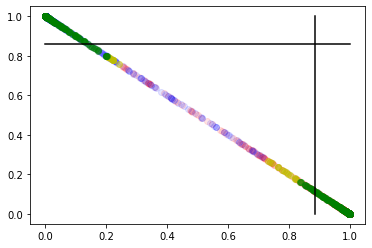

In [247]:
'''method improved'''
ylabed_2 = keras.utils.to_categorical(ylabed)
num_00 = int(np.round(len([i for i in range(len(ypred)) if ypred[i][0] < t0 and ypred[i][1] < t1]) *matrix_q[0][1]))
num_11 = int(np.round(len([i for i in range(len(ypred)) if ypred[i][0] < t0 and ypred[i][1] < t1]) *matrix_q[1][0]))
num_0 = int(np.round(len(ylabed) * matrix_q[0][1]))
num_1 = int(np.round(len(ylabed) * matrix_q[1][0]))
l_0 = sorted([(ypred[i][0],int(i)) for i in t[0]],key= lambda x: x[0])

exclude_0 = [p[1] for p in l_0[:num_0]]
modified_0 = [p[1] for p in l_0[num_0:num_0+num_00]]
reserved_0 = [p[1] for p in l_0[num_0+num_00:]]

l_1 = sorted([(ypred[i][1],int(i)) for i in t[1]],key= lambda x: x[0])
exclude_1 = [p[1] for p in l_1[:num_1]]
modified_1 = [p[1] for p in l_1[num_1:num_1+num_11]]
reserved_1 = [p[1] for p in l_1[num_1+num_11:]]

print(len(l_0),len(l_1))

ex_0 = np.array([ypred[i] for i in exclude_0])
ex_1 = np.array([ypred[i] for i in exclude_1])

p_00 = matrix_q[0][0] / (matrix_q[0][0] + matrix_q[0][1])
p_11 = matrix_q[1][1] / (matrix_q[1][0] + matrix_q[1][1])

modified = []

for i in modified_0:
    if ypred[i][0] < ypred[i][1]:
        ylabed_2[i][0] = p_00
        ylabed_2[i][1] = 1 - p_00
        modified.append(i)
    else:
        reserved_0.append(i)
for i in modified_1:
    if ypred[i][0] > ypred[i][1]:
        ylabed_2[i][0] = 1 - p_11
        ylabed_2[i][1] = p_11
        modified.append(i)
    else:
        reserved_1.append(i)


ex = np.array([ypred[i] for i in exclude_0] + [ypred[i] for i in exclude_1])
mo = np.array([ypred[i] for i in modified])
re_0 = np.array([ypred[i] for i in reserved_0])
re_1 = np.array([ypred[i] for i in reserved_1])
# re = np.array([ypred[i] for i in reserved])
# plt.scatter(ypred[:,0],ypred[:,1])

plt.scatter(re_0[:,0], re_0[:,1], color='r',alpha=0.1)
plt.scatter(re_1[:,0], re_1[:,1], color='b',alpha=0.1)
plt.scatter(mo[:,0],mo[:,1],color='y',alpha=0.5)
plt.scatter(ex[:,0],ex[:,1],color='g',alpha=0.5)
plt.plot([t0,t0],[0,1],color='black')
plt.plot([0,1],[t1,t1],color='black')

In [248]:
reserved_id = np.array(reserved_0 + reserved_1)
perm = random.sample(range(len(reserved_id)),len(reserved_id))
reserved_id = reserved_id[perm[:len(perm)]]
train_x = lstm_x[reserved_id]
train_y = ylabed_2[reserved_id]
print(len(train_x))
model = creat_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.fit(train_x, train_y, epochs=200, batch_size=128, validation_split=0.1, callbacks=[EarlyStopping(patience=10),ModelCheckpoint(filepath='./cl_im2.h5', save_best_only=True)], shuffle=True, verbose=2,)


2486
Epoch 1/200
18/18 - 4s - loss: 0.5161 - accuracy: 0.7908 - val_loss: 0.3248 - val_accuracy: 0.9116
Epoch 2/200
18/18 - 1s - loss: 0.3037 - accuracy: 0.9008 - val_loss: 0.2327 - val_accuracy: 0.9157
Epoch 3/200
18/18 - 1s - loss: 0.2445 - accuracy: 0.9303 - val_loss: 0.2098 - val_accuracy: 0.9116
Epoch 4/200
18/18 - 1s - loss: 0.2198 - accuracy: 0.9347 - val_loss: 0.1911 - val_accuracy: 0.9277
Epoch 5/200
18/18 - 1s - loss: 0.1968 - accuracy: 0.9370 - val_loss: 0.1620 - val_accuracy: 0.9317
Epoch 6/200
18/18 - 1s - loss: 0.1693 - accuracy: 0.9513 - val_loss: 0.1405 - val_accuracy: 0.9277
Epoch 7/200
18/18 - 1s - loss: 0.1527 - accuracy: 0.9553 - val_loss: 0.1259 - val_accuracy: 0.9398
Epoch 8/200
18/18 - 1s - loss: 0.1438 - accuracy: 0.9562 - val_loss: 0.1217 - val_accuracy: 0.9478
Epoch 9/200
18/18 - 1s - loss: 0.1332 - accuracy: 0.9616 - val_loss: 0.1200 - val_accuracy: 0.9558
Epoch 10/200
18/18 - 1s - loss: 0.1260 - accuracy: 0.9651 - val_loss: 0.1210 - val_accuracy: 0.9478
Epoc

In [ ]:
train_lstm_x = lstm_x[:int(len(lstm_x)*0.8)]
train_y = labels[:int(len(labels)*0.8)]
test_lstm_x = lstm_x[int(len(lstm_x)*0.8):]
test_y = labels[int(len(labels)*0.8):]

In [72]:
a = np.array([5,7,1])
print(sorted(a))

[1, 5, 7]


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K


model = keras.Sequential()
model.add(keras.layers.Bidirectional(keras.layers.LSTM(50, return_sequences=True),input_shape=(lstm_x.shape[1], lstm_x.shape[2])))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(300, activation='relu', kernel_regularizer=None, bias_regularizer=None))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=None, bias_regularizer=None))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(2, activation='sigmoid', kernel_regularizer=None, bias_regularizer=None,name='4'))
model.add(keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=None, bias_regularizer=None))

# print(model.summary())

adam = keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=adam, loss=focal_loss, metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(train_lstm_x, train_y, epochs=300, batch_size=128, validation_split=0.1,
                        callbacks=[EarlyStopping(patience=10), ModelCheckpoint(filepath='./' + 'lstm_0.h5', save_best_only=True)],
                        shuffle=True, verbose=2)
loss, accuracy = model.evaluate(test_lstm_x, test_y)
print("loss=",loss,'acc=',accuracy)